# Predicting The Past
-----------------------------------------------------------------------------------------------------------------------------
*Welcome to the third part of the project. The target is to predict the happiness levels of people from different countries all the way back to 1990. But why 1990? Why not even farther? The reason is that as years go by, the prediction moves farther from the truth. In our case happiness is a subjective variable. That means people were asked how they feel and each one makes different sense of happiness. The result is considered reliable for some, while others believe the opposite. But no matter what everyone believes no one can argue that variables play the same role in all years. The % of internet users is such an example. This set doesn't contain measurements of happiness levels before 2005 but we shouldn't assume that people were miserable in the 70's or 60's because they didn't have Facebook. Surely, this variable can be used as an indicator of gdp or access to education, but only in the time period it exists. Another problem is the fact that as we move in the past even more data are missing and that will drop the prediction accuracy even more.*

In [1]:
#Importing modules and data
from sklearn.preprocessing import scale
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
train = pd.read_csv("C:\\Users\\nikos\\Desktop\\thesisdata\\2005to2014train.csv")
test = pd.read_csv("C:\\Users\\nikos\\Desktop\\thesisdata\\1990to2004test.csv")

First thing we are going to attempt will be to create a model using the data from 2014, to predict happiness in the years 2005-2013. After doing so we are going to evaluate the model and create a new one to do the same thing (using all the data from 2005 to 2014) to predict the past (back to 1990). Why two models? Using just one model with 2014 data introduces a constraint in the data that will be used. That means that since I used only 2014 data to construct the model and test it in the years 2005-2013, I would have to use the same model to predict from 2004 and backwards. But why do that when we have data from 2005 to 2014 to use for training? We could maneuver this issue using just one model and evaluating it using cross-validation or train-test split. But that yields another serious problem. Since the data we are dealing with are of macroeconomic nature, changes between the years exist but are not that significant. So using traditional train-validation split to evaluate the model would result in overfitting (R^2~0.89). So we will use a 2-model methodology. By using this methodology we are making assumptions that seem reasonable but do not necessarily hold. We assume that the overall gain in predictive power (by using more data) will be about equal to the loss we will have for making predictions in a different but near timeframe. For example, if we used internet users to train a model today and use it to predict happiness in 1990,that would result in a biased prediction. Simply put, we assume that the relationship between happiness and the feautures we used doesn't change through time.

In [2]:
#removing internet users from features
internet = 'Internet users (per 100 people)'
trainset = train[train.Year==2014]
testset = train[train.Year!=2014]
Xtrain = trainset.drop(["Country","Life Ladder","Year",internet],axis=1)
Xtest = testset.drop(["Country","Life Ladder","Year",internet],axis=1)
ytrain = trainset.iloc[:,1]
ytest = testset.iloc[:,1]
GradientBoostingRegressor
params = {'n_estimators': 2000, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'ls',"random_state":2}
clf = GradientBoostingRegressor(**params)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
r2_score(ytest, clf.predict(Xtest))

0.79784296572327429

Let's plot the predicted versus the real values

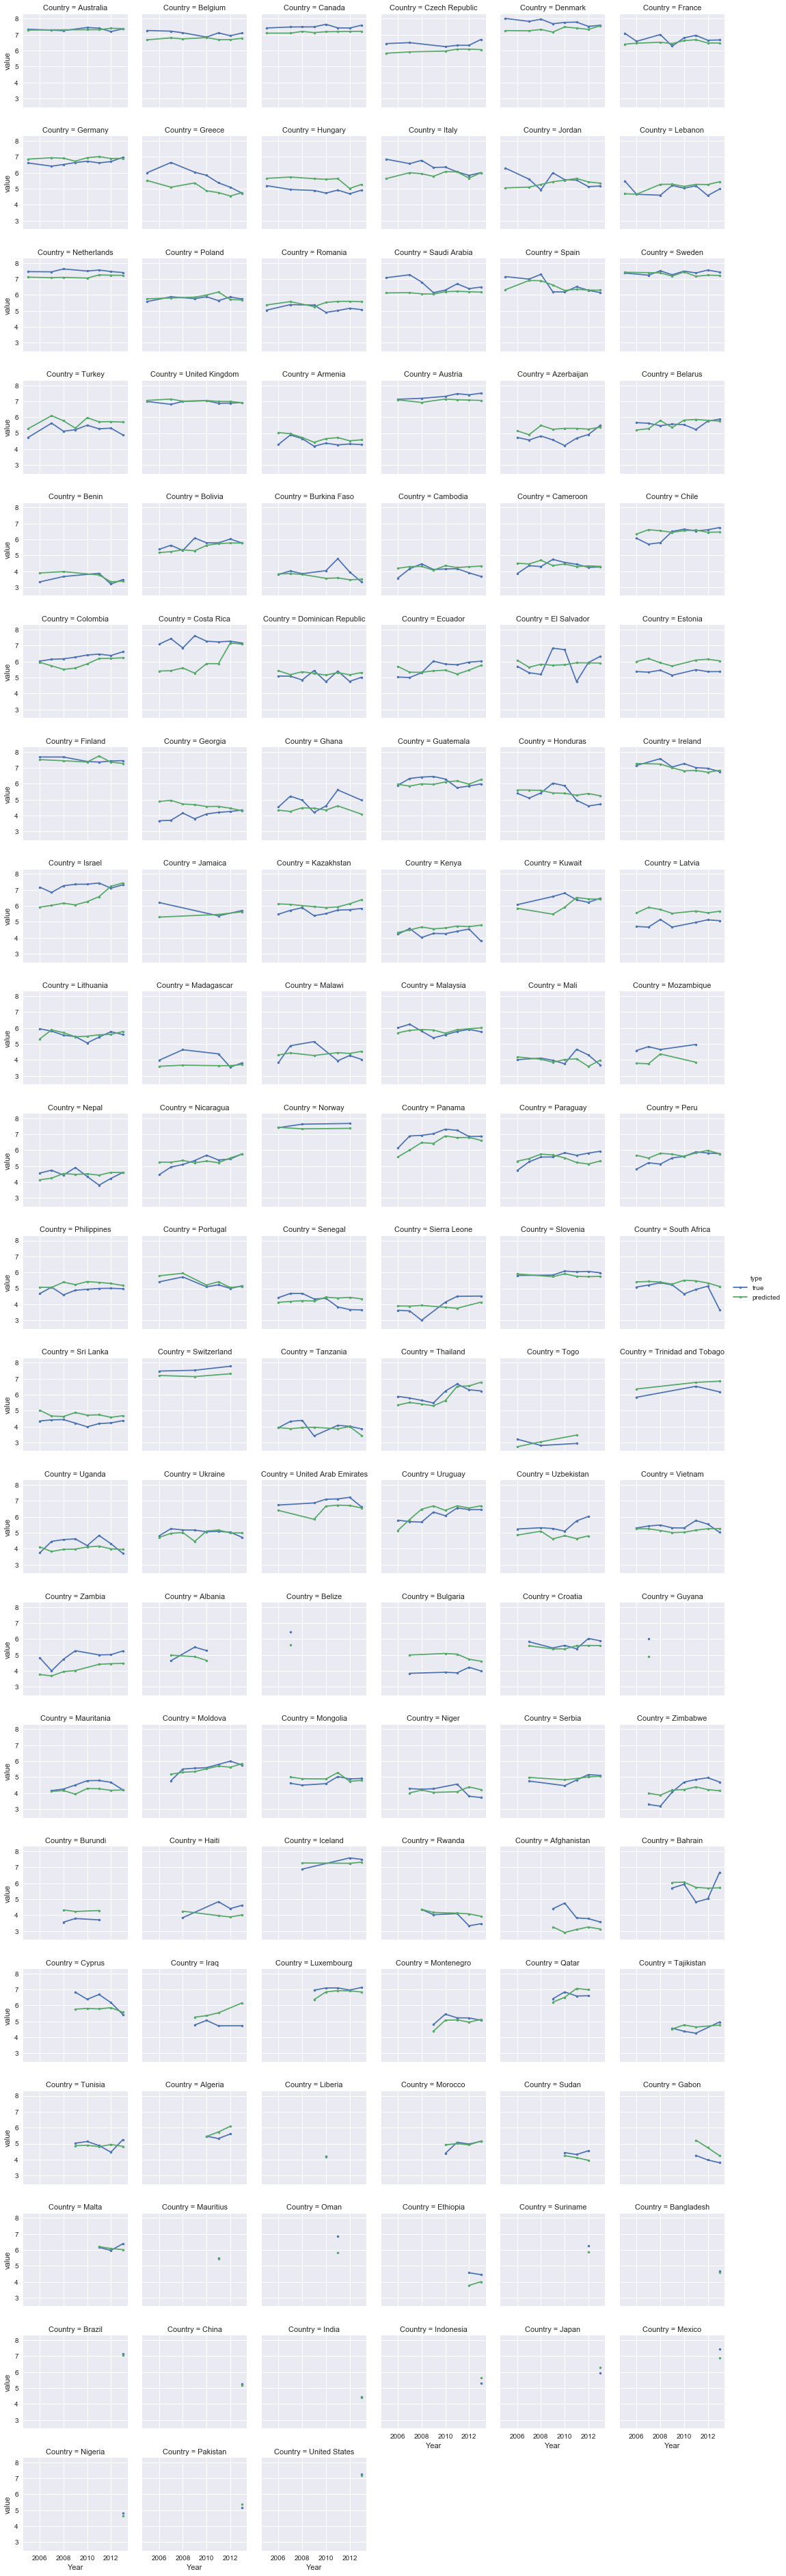

In [3]:
trueframe=pd.DataFrame([ytest,train.Year,train.Country]).transpose().dropna()
trueframe = trueframe.rename(columns={'Life Ladder':'value'})
trueframe['type'] = 'true'
predframe=pd.DataFrame([ypred,train.Year,train.Country]).transpose().dropna()
predframe = predframe.rename(columns={0:'value',1:'Year',2:'Country'})
predframe['type'] = 'predicted'
truepred = pd.concat([trueframe,predframe])

g = sns.FacetGrid(truepred, col="Country", col_wrap=6, size=2.5,hue='type')
g = (g.map(plt.plot, "Year", "value", marker=".").add_legend())

Using data from 2005 to 2014 to train the algorithm

In [4]:
Xtrain = train.drop(["Country","Life Ladder",internet,"Year"],axis=1)
Xtest = test.drop(["Country",internet,"Year"],axis=1)
ytrain = train.iloc[:,1]
#The model
params = {'n_estimators': 2000, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'ls','random_state':2}
clf = GradientBoostingRegressor(**params)
clf.fit(Xtrain, ytrain)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=2000,
             presort='auto', random_state=2, subsample=1.0, verbose=0,
             warm_start=False)

Question 1 : _"Does global happiness change over time?"_

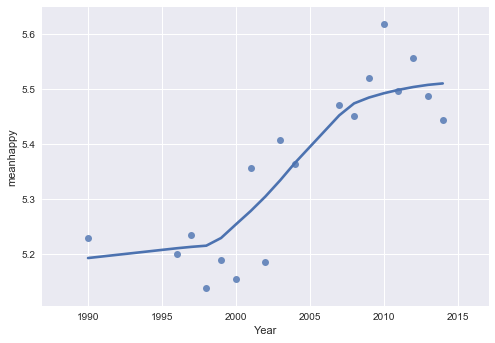

In [7]:
#the prediction
prediction = clf.predict(Xtest)
yy = train.iloc[:,1]
truedf=pd.DataFrame([yy,train.Year,train.Country,train.iloc[:,4]]).transpose().dropna()
truedf = truedf.rename(columns={'Life Ladder':'value','GDP per capita, PPP (current international $)':'gdpcap'})
truedf['type'] = 'true'
preddf=pd.DataFrame([prediction,test.Year,test.Country,test.iloc[:,3]]).transpose().dropna()
preddf = preddf.rename(columns={0:'value',1:'Year',2:'Country',3:'gdpcap'})
preddf['type'] = 'predicted'
seriesdf = pd.concat([truedf,preddf])
seriesdf = seriesdf.sort_values("Year")
list1 =[]
list2 =[]
for year in range(1990,2015):
    list1.append(seriesdf.value[seriesdf.Year==year].mean())
    list2.append(seriesdf.gdpcap[seriesdf.Year==year].mean())
globalhappy = pd.DataFrame()
globalhappy["meanhappy"]=list1
globalhappy["meangdp"]=list2
globalhappy["Year"]=set(seriesdf.Year)
ncount = []
for year in range(1990,2015):
    ncount.append(seriesdf[seriesdf.Year==year].shape[0])
globalhappy["ncountries"] = ncount
globalhappy.meangdp /= max(globalhappy.meangdp)
sns.regplot(x="Year",y="meanhappy",data=globalhappy[(globalhappy.ncountries>70)],lowess=True)

The predicted world happiness is increasing in the specific timeframe at a rate about 0.012/year whereas researchers with real data have measured a rate about 0.006/year. Of course these are not the real happiness values so it's expected.

Question 2 : _"Do these predictions satisfy the Easterlin paradox?"_

>The Easterlin paradox is a concept in happiness economics. It is named after the economist Richard Easterlin, who suggested that a higher level of a country's per capita gross domestic product did not correlate with greater self-reported levels of happiness among citizens of a country, in contrast with people inside a country.

In the previous part we showed that the 'GDP per capita' feature was among the most important features both in the Lasso and the Gradient Boosting algorithms. So these results do not agree with the Easterlin paradox. This time we will check if true values, with some predictions of happiness added, correlate with gdp per capita. To avoid using preditions with low accuracy just 2000-2004 predictions will be used and of course the real data from 2005 to 2014.

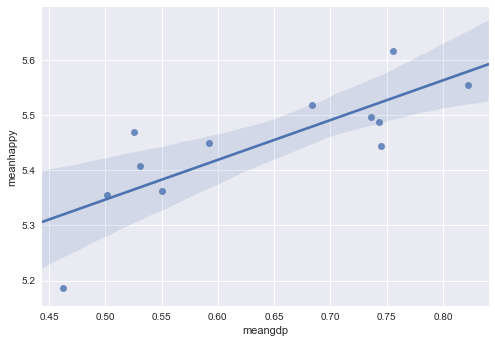

In [8]:
sns.regplot(y="meanhappy",x="meangdp",data=globalhappy[(globalhappy.ncountries>70)&(globalhappy.Year>2000)])

In [13]:
#Correlation only for real data
globalhappy[globalhappy.Year>2004].corr().iloc[:2,:2]

,meanhappy,meangdp
meanhappy,1.000000,0.815448
meangdp,0.815448,1.000000


In [14]:
#Correlation for mixed real predicted data
globalhappy[globalhappy.Year>2000].corr().iloc[:2,:2]

,meanhappy,meangdp
meanhappy,1.000000,0.821514
meangdp,0.821514,1.000000


So there seems to be a linear relationship in the long run too either using the real data or the true-predicted mix.

Finishing our analysis let's take a look at the predicted happiness for some European countries. In the following plot the points from 2005 and later are the true values, while the previous points are predictions. Observe that from 1990-1997 the predicted curves seem to be concentrated in a small zone and that may be due to weak accuracy. 

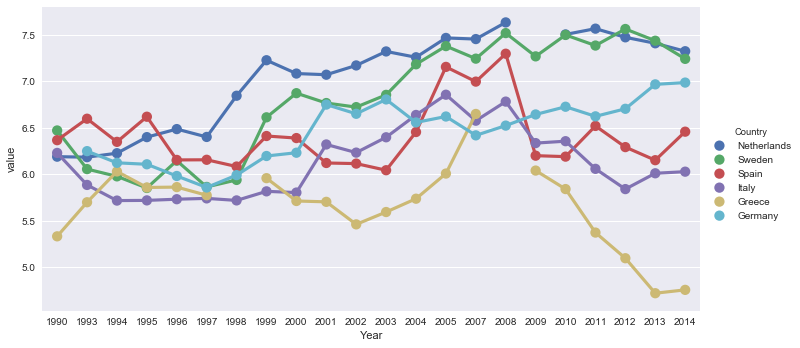

In [6]:
#plotting the final results
yy = train.iloc[:,1]
truedf=pd.DataFrame([yy,train.Year,train.Country]).transpose().dropna()
truedf = truedf.rename(columns={'Life Ladder':'value'})
truedf['type'] = 'true'
preddf=pd.DataFrame([prediction,test.Year,test.Country]).transpose().dropna()
preddf = preddf.rename(columns={0:'value',1:'Year',2:'Country'})
preddf['type'] = 'predicted'
seriesdf = pd.concat([truedf,preddf])
seriesdf = seriesdf.sort_values("Year")
sns.factorplot(data=seriesdf.loc[(seriesdf.Country=="Greece")
                               |(seriesdf.Country=="Sweden")
                               |(seriesdf.Country=="Germany")
                               |(seriesdf.Country=="Spain")
                               |(seriesdf.Country=="Netherlands")
                               |(seriesdf.Country=="Italy")], x='Year', y='value',hue="Country",size=5,aspect=2)

# _The end_
-----------------------------------------------------------------------------------------------------------------------------